**Who Can Follow This Article?**

* No need to be an expert
* Some knowledge about classic technical indicators (RSI, moving average ...)
* Maybe you are already experienced in basic Pandas functionalities
* A quick idea on machine learning predictions in the Forex or stocks Chaos

**What Is Included In This Article?**

* Download prices data from an [online source](https://www.dukascopy.com/swiss/english/marketwatch/historical/)
* Load the data into our framework
* Check and Clean data content
* Quick statistical analysis to reveal hidden patterns
* Is it possible to make predictions based on technical indicators? Stats will answer

**1. Historical Data Feed**

Here, dataset is a CSV file containing candlestick data for the USA30 index (also known as the Dow Jones Industrial Average, DJIA) on a 4-hour interval basis, covering the period from Jan 01 2024, to Jan 18 2025.

**2. Loading And Preparing Data**

In [7]:
import pandas as pd
df = pd.read_csv("Dataset/USA30.IDXUSD_Candlestick_1_Hour_BID_01.01.2024-18.01.2025.csv")
df.tail()

,Local time,Open,High,Low,Close,Volume
9212,18.01.2025 19:30:00.000 GMT+0330,43464.799,43464.799,43464.799,43464.799,0.0
9213,18.01.2025 20:30:00.000 GMT+0330,43464.799,43464.799,43464.799,43464.799,0.0
9214,18.01.2025 21:30:00.000 GMT+0330,43464.799,43464.799,43464.799,43464.799,0.0
9215,18.01.2025 22:30:00.000 GMT+0330,43464.799,43464.799,43464.799,43464.799,0.0
9216,18.01.2025 23:30:00.000 GMT+0330,43464.799,43464.799,43464.799,43464.799,0.0


**3. Check If Any Zero Volume Are Available**

In [8]:
# Find the indices where 'Volume' is 0
indexZeros = df[df['Volume'] == 0].index

# Drop the rows where 'Volume' is 0
df.drop(indexZeros, inplace=True)

# Correctly select rows where 'Volume' is 0 (if needed for verification)
zero_volume_rows = df[df['Volume'] == 0]

# If you want to print or see the result of the selection
print(zero_volume_rows)

Empty DataFrame
Columns: [Local time, Open, High, Low, Close, Volume]
Index: []


**4. Check for missing values**

In [9]:
df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

**5. Imports and Data Preparation**

In [12]:
import numpy as np
import pandas_ta as ta
from scipy.stats import linregress

**6. Calculating Technical Indicators**

In [13]:
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1)  # midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

**7. Define get_slope Function**

In [14]:
def get_slope(array):
    y = np.array(array)
    x = np.array(array)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

**8. Set Rolling Window Size**

In [15]:
backrollingN = 6

**9. Calculate Slopes**

In [16]:
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

**10. Display the DataFrame**

In [17]:
df.tail()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
9189,17.01.2025 20:30:00.000 GMT+0330,43595.787,43659.999,43564.215,43607.727,0.7086,80.822223,79.557206,43612.107,43246.91550,42970.395475,42638.070825,1.0,1.0,1.0,1.0,1.0
9190,17.01.2025 21:30:00.000 GMT+0330,43608.787,43626.799,43541.739,43566.999,0.7250,81.034112,73.753594,43584.269,43254.79305,42985.137025,42645.170825,1.0,1.0,1.0,1.0,1.0
9191,17.01.2025 22:30:00.000 GMT+0330,43568.227,43570.997,43507.215,43525.739,0.7428,80.171507,68.316517,43539.106,43261.57030,42998.578275,42651.181700,1.0,1.0,1.0,1.0,1.0
9192,17.01.2025 23:30:00.000 GMT+0330,43523.737,43564.799,43477.763,43482.739,0.9587,80.514731,63.096061,43521.281,43267.07165,43011.519675,42658.357025,1.0,1.0,1.0,1.0,1.0
9193,18.01.2025 00:30:00.000 GMT+0330,43482.737,43490.999,43458.775,43464.799,0.1316,78.100195,61.001645,43474.887,43272.24980,43024.136525,42664.326625,1.0,1.0,1.0,1.0,1.0


**11. Target Categories**

In [18]:
#Target flexible way
pipdiff = 100 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat


# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
27,02.01.2024 02:30:00.000 GMT+0330,37688.719,37742.749,37688.219,37722.759,0.0480,NaN,NaN,37715.484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
28,02.01.2024 03:30:00.000 GMT+0330,37723.279,37731.499,37710.719,37716.759,0.0233,NaN,NaN,37721.109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
29,02.01.2024 04:30:00.000 GMT+0330,37717.699,37737.499,37698.759,37706.729,0.0540,NaN,NaN,37718.129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
30,02.01.2024 05:30:00.000 GMT+0330,37707.739,37717.289,37704.769,37715.499,0.0294,NaN,NaN,37711.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31,02.01.2024 06:30:00.000 GMT+0330,37715.999,37724.249,37712.219,37721.759,0.0207,NaN,NaN,37718.234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


**12. Quick Analysis Example**

C:\Users\yas\AppData\Local\Temp\ipykernel_12048\532070288.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


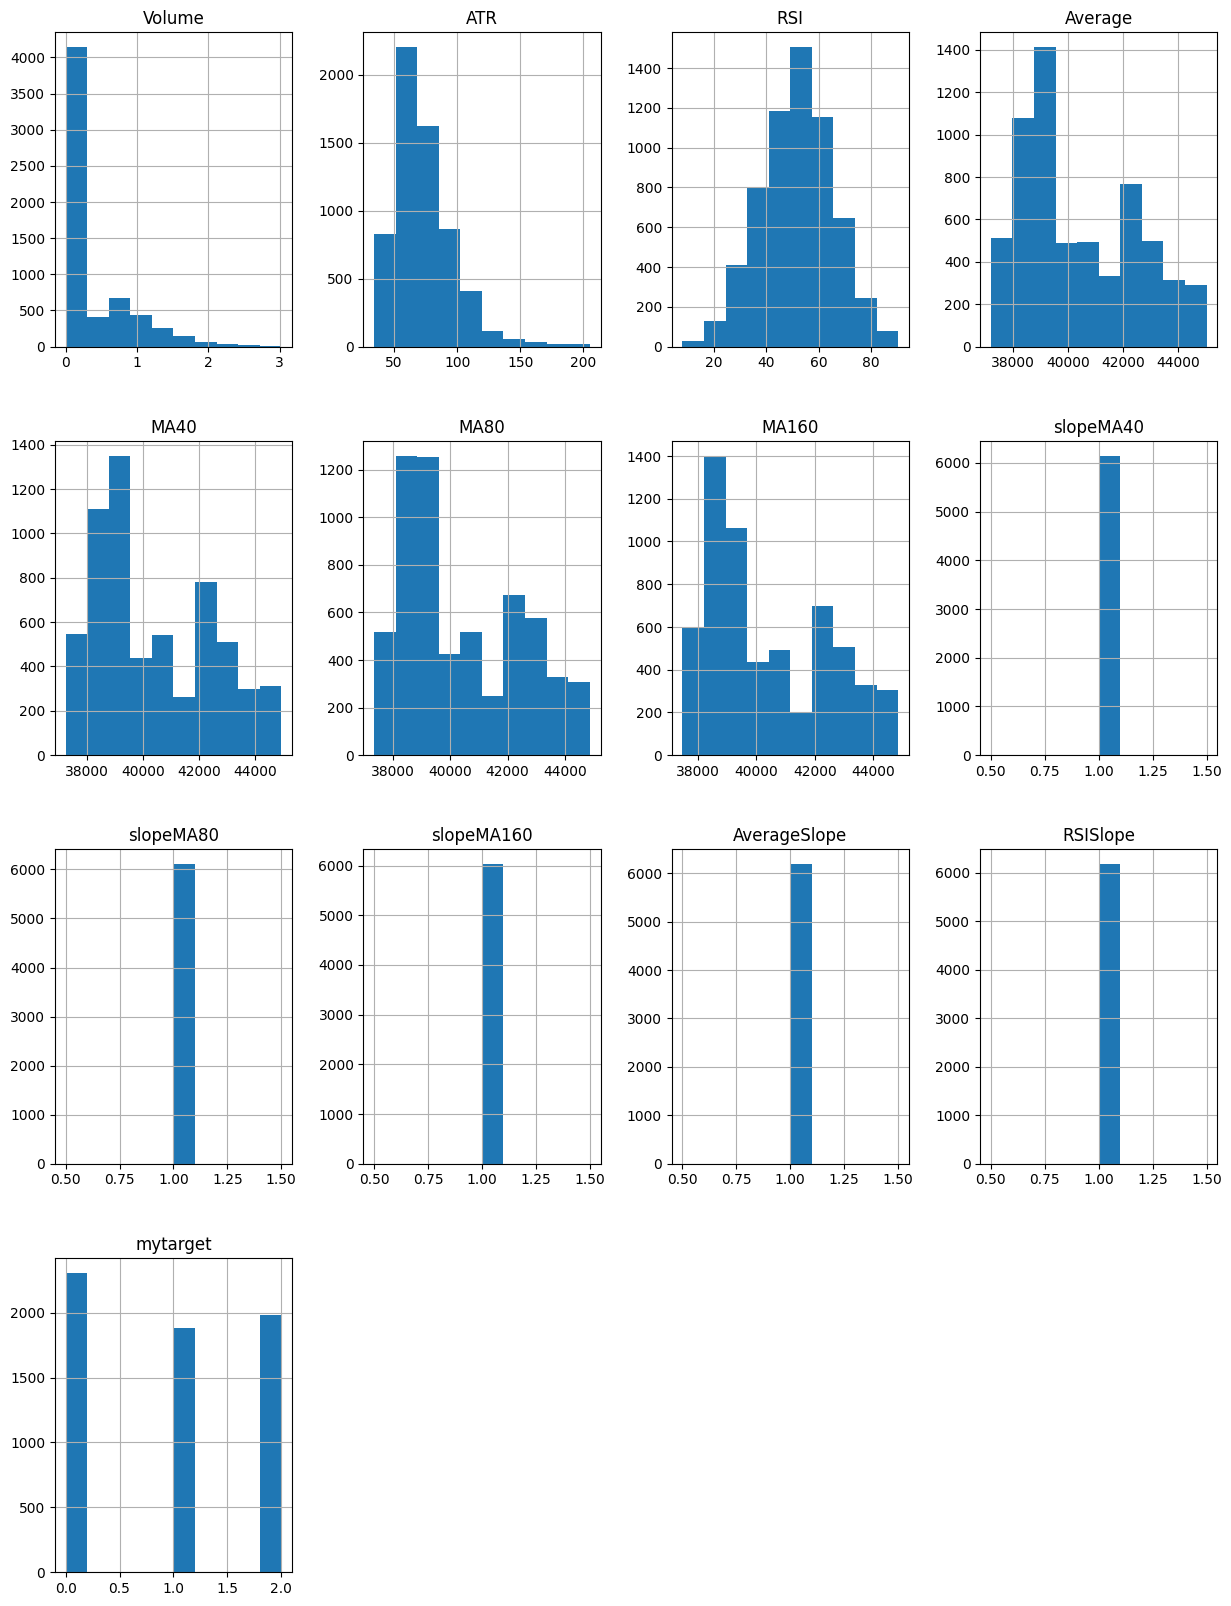

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

**13. Can We Use The RSI Alone As a Trend Indicator?**

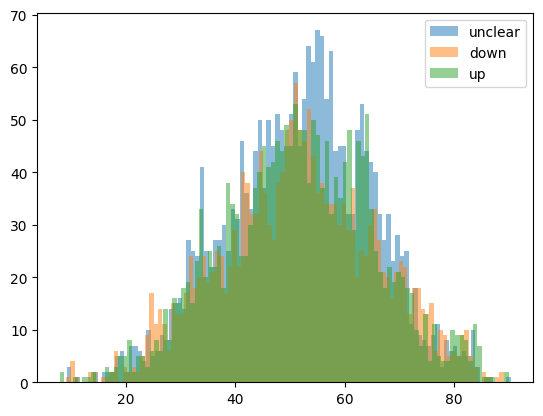

In [20]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()